# Environmental setup

In [1]:
# %load ~/python/my_import.py
# BASIC
import numpy as np
import xarray as xr
import pandas as pd

#xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays
import os
os.environ['HDF5_PLUGIN_PATH'] = '/work/bm0021/conda-envs/eerie_io/lib/python3.11/site-packages/hdf5plugin/plugins'

# matplotlib
import matplotlib
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.tri as mtri
import matplotlib.dates as md
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib import ticker
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['axes.linewidth'] = 1.5

## color
from matplotlib import cm
import cmocean
import seaborn as sns

## cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point


# scipy
from scipy import stats
from scipy import optimize
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from scipy.stats import binned_statistic
import scipy.spatial.qhull as qhull


# metpy
import metpy
import metpy.calc as mpcalc


# etc
import subprocess
import time
import datetime
from datetime import timedelta
import calendar


# Dask
import dask # Distributed data libary
from dask import delayed
from dask import compute
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from distributed import Client, progress # Libaray to orchestrate distributed resources
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

from pathlib import Path
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib.dates import DateFormatter

In [2]:
def cut_region(model_lon, model_lat, elements, box):
    """
    Return mesh elements (triangles) and their indices corresponding to a bounding box.
    Parameters
    ----------
    model_lon : 1d numpy array
        longitudes of mesh vertices
    model_lat : 1d numpy array
        latitudes of mesh vertices
    box : list
        Coordinates of the box in [-180 180 -90 90] format.
    Returns
    -------
    elem_no_nan : array
        elements that belong to the region defined by the `box`.
    no_nan_triangles: array
        boolean array of element size with True for elements
        that belong to the `box`.
    """
    left, right, down, up = box

    selection = (
        (model_lon >= left)
        & (model_lon <= right)
        & (model_lat >= down)
        & (model_lat <= up)
    )

    elem_selection = selection[elements]

    no_nan_triangles = np.all(elem_selection, axis=1)

    elem_no_nan = elements[no_nan_triangles]

    return elem_no_nan, no_nan_triangles

def get_no_cyclic(model_lon, model_lat, elem_no_nan):
    """Compute non cyclic elements of the mesh."""
    d = model_lon[elem_no_nan].max(axis=1) - model_lon[elem_no_nan].min(axis=1)
    no_cyclic_elem = np.argwhere(d < 100)
    return no_cyclic_elem.ravel()


# Read data

### ESA CCI

In [3]:
dpath = '/work/mh0731/m300793/data/landuse/'

esacci = xr.open_mfdataset(f'{dpath}/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7cds.nc') #\
        #    .isel(lat=slice(int(32400/2-50),int(32400/2+50))).isel(lon=slice(int(129600/2-50),int(129600/2+50)))
esacci

<xarray.Dataset>
Dimensions:              (time: 1, lat: 64800, lon: 129600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 90.0 90.0 89.99 ... -89.99 -90.0 -90.0
  * lon                  (lon) float64 -180.0 -180.0 -180.0 ... 180.0 180.0
  * time                 (time) datetime64[ns] 2015-01-01
Dimensions without coordinates: bounds
Data variables:
    lccs_class           (time, lat, lon) uint8 dask.array<chunksize=(1, 64800, 129600), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 dask.array<chunksize=(1, 64800, 129600), meta=np.ndarray>
    current_pixel_state  (time, lat, lon) float32 dask.array<chunksize=(1, 64800, 129600), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 dask.array<chunksize=(1, 64800, 129600), meta=np.ndarray>
    change_count         (time, lat, lon) uint8 dask.array<chunksize=(1, 64800, 129600), meta=np.ndarray>
    crs                  int32 ...
    lat_bounds           (lat, bounds) float64 dask.array<chunksize=(64800, 2), meta=np.ndarray>
    lon_bounds           (lon, bounds) float64 dask.array<chunksize=(129600, 2), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

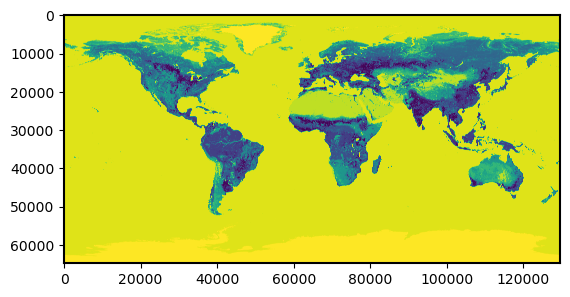

In [4]:
# test plot
plt.imshow(esacci['lccs_class'].isel(time=0))

### Cross-walking table

In [5]:
cross_table = pd.read_csv(f'{dpath}/JSBACH4_11PFTs_CONFESS_LCCS2PFT_LUT_Junhong.csv', sep='|')
cross_table

LCCS_Class  pft01  pft02  pft03  pft04  pft05  pft06  pft07  pft08  pft09   
0            0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  \
1           10    NaN    NaN    NaN    NaN    NaN    NaN   10.0    NaN    NaN   
2           11    NaN    NaN    NaN    NaN    NaN    NaN   10.0    NaN    NaN   
3           12    NaN    NaN    NaN    NaN    NaN   70.0    NaN    NaN    NaN   
4           20    NaN    NaN    NaN    NaN    NaN    NaN   10.0    NaN    NaN   
5           30    5.0    5.0    NaN    NaN   10.0    5.0   15.0    NaN    NaN   
6           40    7.5    7.5    NaN    NaN   20.0   15.0   30.0    NaN    NaN   
7           50   90.0    NaN    NaN    NaN    5.0    5.0    NaN    NaN    NaN   
8           60    NaN   50.0    NaN    NaN    NaN   20.0   30.0    NaN    NaN   
9           61    NaN   70.0    NaN    NaN    NaN   15.0   15.0    NaN    NaN   
10          62    NaN   30.0    NaN    NaN    NaN   25.0   45.0    NaN    NaN   
11          70    NaN    NaN   70.0    NaN   10.0    5.0   15.0    NaN    NaN   
12          71    NaN    NaN   70.0    NaN   10.0    5.0   15.0    NaN    NaN   
13          72    NaN    NaN   30.0    NaN   25.0    NaN   45.0    NaN    NaN   
14          80    NaN    NaN    NaN   50.0    5.0   15.0   30.0    NaN    NaN   
15          81    NaN    NaN    NaN   70.0    5.0   10.0   15.0    NaN    NaN   
16          82    NaN    NaN    NaN   30.0    NaN   25.0   45.0    NaN    NaN   
17          90    NaN   30.0   20.0   10.0   10.0    5.0   25.0    NaN    NaN   
18         100   10.0   20.0    5.0    5.0   10.0   10.0   40.0    NaN    NaN   
19         110    5.0   10.0    5.0    NaN   10.0   10.0   60.0    NaN    NaN   
20         120    NaN    NaN    NaN    NaN   20.0   50.0   30.0    NaN    NaN   
21         121    NaN    NaN    NaN    NaN   70.0    NaN   30.0    NaN    NaN   
22         122    NaN    NaN    NaN    NaN    NaN   70.0   30.0    NaN    NaN   
23         130    NaN    NaN    NaN    NaN    NaN    NaN  100.0    NaN    NaN   
24         140    NaN    NaN    NaN    NaN    NaN    NaN  100.0    NaN    NaN   
25         150    NaN    5.0    5.0    NaN    5.0    5.0   30.0    NaN    NaN   
26         151   10.0   10.0    NaN    NaN    NaN    NaN   30.0    NaN    NaN   
27         152    NaN    NaN    NaN    NaN   10.0   10.0   30.0    NaN    NaN   
28         153    NaN    NaN    NaN    NaN    NaN    NaN   50.0    NaN    NaN   
29         160   37.5   37.5    NaN    NaN    NaN    NaN   25.0    NaN    NaN   
30         170   75.0    NaN    NaN    NaN   25.0    NaN    NaN    NaN    NaN   
31         180    NaN    NaN    NaN    NaN    5.0    5.0   10.0    NaN    NaN   
32         190    NaN    2.5    2.5    NaN    NaN    NaN   20.0    NaN    NaN   
33         200    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
34         201    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
35         202    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
36         210    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
37         220    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

    pft10  pft11  no_Data  
0     NaN    NaN    100.0  
1     NaN   90.0      NaN  
2     NaN   90.0      NaN  
3     NaN   30.0      NaN  
4     NaN   90.0      NaN  
5     NaN   60.0      NaN  
6     NaN   20.0      NaN  
7     NaN    NaN      NaN  
8     NaN    NaN      NaN  
9     NaN    NaN      NaN  
10    NaN    NaN      NaN  
11    NaN    NaN      NaN  
12    NaN    NaN      NaN  
13    NaN    NaN      NaN  
14    NaN    NaN      NaN  
15    NaN    NaN      NaN  
16    NaN    NaN      NaN  
17    NaN    NaN      NaN  
18    NaN    NaN      NaN  
19    NaN    NaN      NaN  
20    NaN    NaN      NaN  
21    NaN    NaN      NaN  
22    NaN    NaN      NaN  
23    NaN    NaN      NaN  
24    NaN    NaN      NaN  
25    NaN    NaN     50.0  
26    NaN    NaN     50.0  
27    NaN    NaN     50.0  
28    NaN    NaN     50.0  
29  

# Convert ESA CCI to JSBACH PFTs

### Create variable

In [8]:
drop_var = ["lccs_class", "processed_flag", "change_count", "crs", "current_pixel_state", "observation_count"]

esacci_pft = esacci.copy(deep=True)
esacci_pft = esacci_pft.drop_vars(drop_var)
esacci_pft

<xarray.Dataset>
Dimensions:      (lat: 64800, lon: 129600, bounds: 2, time: 1)
Coordinates:
  * lat          (lat) float64 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * lon          (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time         (time) datetime64[ns] 2015-01-01
Dimensions without coordinates: bounds
Data variables:
    lat_bounds   (lat, bounds) float64 dask.array<chunksize=(64800, 2), meta=np.ndarray>
    lon_bounds   (lon, bounds) float64 dask.array<chunksize=(129600, 2), meta=np.ndarray>
    time_bounds  (time, bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [12]:
max_pft = 11
pft_list = []

lat_size, lon_size = esacci_pft.lat.size, esacci_pft.lon.size
for pft in np.arange(1, max_pft+1):
    pft_list.append('fract_pft'+'{:02d}'.format(pft))

for pft in pft_list:
    esacci_pft[pft] = (['lat','lon'], np.zeros((lat_size, lon_size)))
    
esacci_pft

<xarray.Dataset>
Dimensions:      (lat: 64800, lon: 129600, bounds: 2, time: 1)
Coordinates:
  * lat          (lat) float64 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * lon          (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time         (time) datetime64[ns] 2015-01-01
Dimensions without coordinates: bounds
Data variables: (12/14)
    lat_bounds   (lat, bounds) float64 dask.array<chunksize=(64800, 2), meta=np.ndarray>
    lon_bounds   (lon, bounds) float64 dask.array<chunksize=(129600, 2), meta=np.ndarray>
    time_bounds  (time, bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    fract_pft01  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft02  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft03  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    fract_pft06  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft07  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft08  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft09  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft10  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft11  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

### Extract

In [13]:
lccs_class_np = esacci['lccs_class'].isel(time=0).values

In [14]:
fract_np = {}
for pft in pft_list:
    fract_np[pft] = np.zeros( (lat_size, lon_size) )

In [15]:
# lccs_class_np = esacci['lccs_class'].isel(time=0).values
cross_table_np = cross_table.values
lccs_class_idx = cross_table_np[:, 0].astype(np.uint8)[1:-5]

# for x in np.arange(1, 12, 1):
#     if x < 10:
#         xx = '0'+str(x)
#     else:
#         xx = str(x)
#     exec( f'fract_pft{xx}_np = np.zeros_like(lccs_class_np).astype(np.float)' )

In [20]:
for pft_idx, pft in zip(np.arange(1, max_pft+1), pft_list):

    i = 0
    for class_idx in lccs_class_idx:
        
        pft_fract = cross_table_np[i, pft_idx]/100.
        
        if np.isnan(pft_fract):
            pft_fract = 0.

        fract_np[pft] [lccs_class_np==class_idx] = pft_fract

        # print( idx )
        i += 1
        

In [ ]:
for xx in np.arange(lat_size):
    for yy in np.arange(lon_size):

        check_sum = 0
        for pft in pft_list:
            check_sum = check_sum + fract_np[pft] [xx,yy]
            
            break
        break
    break

In [ ]:
# i = 0
# for idx in lccs_class_idx:
    
#     for pft_idx in np.arange(1, 12, 1):
#         pft_fract = cross_table_np[i, pft_idx]/100.

#         if np.isnan(pft_fract):
#             pft_fract = 0.
            
#         if pft_idx < 10:
#             xx = '0'+str(pft_idx)
#         else:
#             xx = str(pft_idx)
#         exec( f'fract_pft{xx}_np[lccs_class_np == idx] = pft_fract' )
#         print( pft_idx )
        
#     print( idx )
#     i += 1

### Construct

In [32]:
esacci_pft['fract_pft01']

<xarray.DataArray 'fract_pft01' (lat: 64800, lon: 129600)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 90.0 90.0 89.99 89.99 ... -89.99 -89.99 -90.0 -90.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0

In [21]:
for pft in pft_list:
    esacci_pft[pft] = (['lat', 'lon'], fract_np[pft])

In [34]:
for x in np.arange(1, 12, 1):
    if x < 10:
        xx = '0'+str(x)
    else:
        xx = str(x)
    exec( f"esacci_pft['fract_pft{xx}'] = (['lat','lon'], fract_pft{xx}_np)" )

##### Test plot

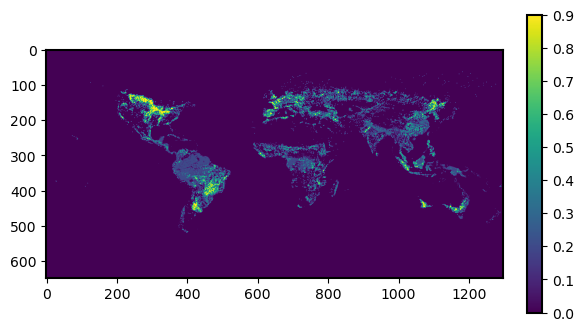

In [25]:
plot_dat = esacci_pft['fract_pft11'].values
img = plt.imshow(plot_dat[::100,::100])
cbar = plt.colorbar(img, orientation='vertical', fraction=0.03, pad=0.05)

In [43]:
esacci_pft

<xarray.Dataset>
Dimensions:      (lat: 64800, lon: 129600, bounds: 2, time: 1)
Coordinates:
  * lat          (lat) float64 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * lon          (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time         (time) datetime64[ns] 2015-01-01
Dimensions without coordinates: bounds
Data variables: (12/14)
    lat_bounds   (lat, bounds) float64 dask.array<chunksize=(64800, 2), meta=np.ndarray>
    lon_bounds   (lon, bounds) float64 dask.array<chunksize=(129600, 2), meta=np.ndarray>
    time_bounds  (time, bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    fract_pft01  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft02  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft03  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    fract_pft06  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft07  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft08  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft09  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft10  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fract_pft11  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [ ]:
rmax, cmax = 3, 4
fig, ax = plt.subplots(nrows=rmax, ncols=cmax, figsize=(15, 9.5), subplot_kw={'projection': ccrs.PlateCarree()},)

for rr in np.arange(rmax):
    for cc in np.arange(cmax):
        ax[rr,cc].coastlines(resolution='110m', color='k')
        ax[rr,cc].add_feature(cfeature.BORDERS, zorder=10, edgecolor='black', facecolor='white')
        # ax[rr,cc].set_extent(box1, crs=ccrs.PlateCarree())

        pft = '{:02d}'.format(rr*cmax + cc + 1)
        if pft == '12':
            ax[rr,cc].set_visible(False)
            break
    
        plot_dat = esacci_pft[f'fract_pft{pft}'].values
        # img = ax[rr,cc].scatter(lon_esa, lat_esa, c=plot_dat[::100,::100], transform=ccrs.PlateCarree())
        img = ax[rr,cc].imshow(plot_dat[::100,::100], transform=ccrs.PlateCarree())

        # cbar = plt.colorbar(img, orientation='vertical', fraction=0.03, pad=0.05)


cax = fig.add_axes([0.2, .91, 0.3, 0.01])
cbar = plt.colorbar(img, orientation='horizontal', fraction=0.050, pad=0.12, ax=ax[:,:], cax=cax)
# cbar.set_ticks([-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0])
# cbar.set_ticklabels([-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# cbar.set_label('correlation coefficient', fontsize=15)

### Write

In [54]:
dpath_out = dpath
esacci_pft.to_netcdf(f'{dpath_out}/ESA_CCI_global_11PFTs.nc', mode='w')

In [ ]:
!cdo remapnn,icon_grid_0015_R02B09_EU.nc ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7cds.nc test.nc